# Final Project: Effect of the Risk Factors on the Incubation Period For COVID-19

## Introduction
A novel human coronavirus, SARS-CoV-2 or COVID-19, was first identified in China in December 2019 and the spreaded out all over the world. There is a limited support for many of its key epidemiologic features, including the incubation period for clinical disease, which has important implications for surveillance and control activities. According to the rough observations, incubation perid is varying widely case by case and is affected by many factors directly and indirectly. 

One of the most important factors affecting on the incubation period for each case is the Risc Factor. For instance, a young healthy person needs much shorter period of time to recover than a old person with pre-existing illness needs. Studying the effect of the risk factors could help us to gain a comperhesnive understanding on this topic, and notifies people how long they to have rest to recover based on their conditons. Finally, this study leads to more effective controlling of the diseases spread.

To this end, we first extract the reported incubation periods within the scientific publications. Then, we find the most well known risk factors for the cases mentioned above. Having analyzed the relation between the risk factors (and their convolution) and the incubation period, we clustered the risk factors to two clusters by taking advantage of unsupervised machine learning:
* High Risk Factors: wich leads to having long period of incubation (> mean incubation period)
* Low Risk Factors: wich leads to having long period of incubation (< mean incubation period)

Having clustered the risk factors, we use supervised machine learning algrithm to develop a model which predicts the incubation period for patients based on their risk factors and pre-existing illness. This model could be beneficial for dedicating hospitals & long-term care facilities to each group of patients.  

In [0]:
!pip install mord
!pip install kaggle

In [0]:
!mkdir .kaggle

In [0]:
#------------------------------------------------
# Connecting to Kaggale API for data downloading
#------------------------------------------------


# import json
# token = {"username":"erfanpirmorad","key":"e7df5babd6f048c1588754cd379f3e59"}
# with open('/content/.kaggle/kaggle.json', 'w') as file: json.dump(token, file)
# !chmod 600 /content/.kaggle/kaggle.json
# !cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
# !kaggle datasets download -d allen-institute-for-ai/CORD-19-research-challenge -p /content
# !mkdir CORD-19-research-challenge
# !unzip CORD-19-research-challenge.zip -d CORD-19-research-challenge 

In [0]:
#----------------------------------------------
# Import Libraries
#----------------------------------------------

import numpy as np
import pandas as pd
import json
import re
import os
import nltk
import mord

from wordcloud import WordCloud
from matplotlib import style
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import wordpunct_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('default')

## Part 0: Data Loading
First of all, we need to load the whole databased which is required for our analysis. As we need the details and numbers for incubation period, we have to mine the provided papers full text. Owing to the fact that the provided "metadata" file does not contain the papers full text, I downladed the .json files containing the full texts of papers and used that by connecting to Kaggle API. (Exact dataset which has been uploaded on google drive and provided is used but downloaded from Kaggle API for ease of use) 

In [0]:
#----------------------------------------------
# Settinp-up directories of the dataset
#----------------------------------------------

root_dirs = ['CORD-19-research-challenge']
dirs = ['biorxiv_medrxiv', 'comm_use_subset', 'noncomm_use_subset', 'custom_license']
docs = list()

After getting access to the full dataset, we use the following peice of code ro parse the JSON files using the key and the values parsion and then save their Title, Abstract, and the full text of all papers.

In [0]:
#----------------------------------------------
# Loading required data from dataset
#----------------------------------------------

for rd in root_dirs:
    for d in dirs:
        for file in (os.listdir(f"{rd}/{d}/{d}")):
            file_path = f"{rd}/{d}/{d}/{file}"
            json_files = [pos_json for pos_json in os.listdir(file_path) if pos_json.endswith('.json')]
            for file_name in json_files:
                j = json.load(open(file_path + '/' + file_name,'rb'))
                title = j['metadata']['title']

                try:
                    abstract = j['abstract'][0]['text']
                except:
                    abstract = ''

                full_text = ''
                for text in j['body_text']:
                    full_text = full_text + text['text'] + '\n\n'
                docs.append([title, abstract, full_text])

In [0]:
df = pd.DataFrame(docs, columns = ['Title', 'Abstract', 'full_text'])
df.head()

,Title,Abstract,full_text
0,Modeling the Epidemic Dynamics and Control of ...,and more than 30 countries over last two month...,The outbreak of coronavirus disease 2019 (COVI...
1,Lipocalin-2 is a Sensitive and Specific Marker...,Introduction. Bacterial infection is the leadi...,Introduction. Bacterial infection remains the ...
2,A data-driven tool for tracking and predicting...,Data-driven approach; prediction of turning po...,number of infected caused by insufficient test...
3,Hydroxychloroquine and azithromycin as a treat...,,"In late December 2019, an outbreak of an emerg..."
4,A Combined Evidence Approach to Prioritize Nip...,Nipah Virus (NiV) came into limelight recently...,Nipah is an infectious negative-sense single-s...


## Part 1: Data Cleaning 
In this part we clean some of our data for the ease of use. As we need to mine the full text of papers we need to do the followings first:
- All characters in the text are set to lowercase letters.
- All stop words are removed. 
- Lemmatizing the words.

In [0]:
#----------------------------------------------
# Removing stopwords
#----------------------------------------------

nltk.download('stopwords')
stop = stopwords.words("english")
df['full_text']=df['full_text'].apply(lambda x:' '.join([word for word in x.split()if word not in (stop)]))

In [0]:
#----------------------------------------------
# Lemmatizing the words
#----------------------------------------------

nltk.download('wordnet')
lemmatize = WordNetLemmatizer()
df['full_text'] = df['full_text'].apply(lambda x: ' '.join([lemmatize.lemmatize(word,'v')for word in x.split()]))

In [0]:
#----------------------------------------------
# Lowecasing the words
#----------------------------------------------

df['full_text'] = df['full_text'].str.lower()

At this point, we need to extract the papers in which we have a keyword related to "incubation" or "recovery" period for further analysis. 

In [0]:
#----------------------------------------------
# Extracting Incubation related texts
#----------------------------------------------

keywords = ["incubate","incubation","recover","recovery","recovering","stay","staying"]
incubation = df[df['full_text'].str.contains(keywords[0])]
for keyword in keywords:
    incubation.append(df[df['full_text'].str.contains(keyword)])

In [0]:
incubation.head(10)

,Title,Abstract,full_text
3,Hydroxychloroquine and azithromycin as a treat...,,"in late december 2019, an outbreak of an emerg..."
5,Coronavirus S protein-induced fusion is blocke...,Enveloped viruses gain entry into host cells b...,coronaviruses are enveloped rna viruses and in...
30,Inactivating porcine coronavirus before nuclei...,Disease 2019. Nucleic acid detection of 2019-n...,severe acute respiratory syndrome coronavirus ...
62,Development and Evaluation of A CRISPR-based D...,The recent outbreak of infections by the 2019 ...,"since the beginning of 2020, a surging number ..."
64,Nucleotide Analogues as Inhibitors of SARS-CoV...,"SARS-CoV-2, a member of the coronavirus family...","formed, which is responsible for making more c..."
69,Programmable low-cost DNA-based platform for v...,Viral detection is critical for controlling di...,newly emerging or re-emerging viruses pose sig...
92,Sensitive one-step isothermal detection of pat...,,increasing global trade and travel are conside...
101,Characterization of anti-viral immunity in rec...,The WHO has declared SARS-CoV-2 outbreak a pub...,"at the end of 2019, patients with coronavirus ..."
102,DNA breaks-mediated cost reveals RNase HI as a...,Understanding the causes of the cost is consid...,introduction different mechanistic basis but a...
112,Microbial and autoantibody immunogenic reperto...,We investigate the accumulated microbial and a...,we investigate the accumulated microbial and a...


In [0]:
text = incubation['full_text'].values

## Part 2: Exploratory analysis
In this part we are going to exlpore the loaded data and imporve our understanding on both the Risk Factors and the incubation periods. First, let's take a look on incubation periods in a genral form and see the range of it.

To explore the incubation periods, we scrutinze the whole full texts word by word and specify the keywords. Then, find the numerical values close to the keywords that is related to that. By using this method we can extract the incubation period for COIVD-19 reported by each sentence of the whole papers and create the database. 

At the begining of the process, we can take a look at the 'Abstract's of the selected papers to make sure that they are relevant and not out of the scope. 

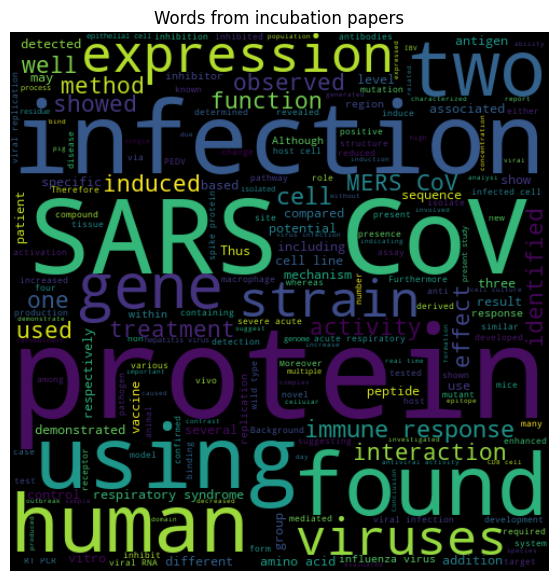

In [0]:
#--------------------------------------------------
# Most repeated words in incubation related papers
#--------------------------------------------------

general = ' '.join([i for i in incubation['Abstract']]) 
wordcloud = WordCloud(width=500,height=500,random_state=40,max_font_size=200).generate(general)

plt.figure(figsize=(7,7))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.title('Words from incubation papers')
plt.show
plt.savefig('words', format='png', bbox_inches='tight', dpi=600)

### 2.1. Incubation period visualization

In [0]:
#----------------------------------------------
# Extracting incubation period numerical value
#----------------------------------------------

keyword_time = list()
for t in text:
    for sentences in t.split(". "):
        for keyword in keywords:
            if keyword in sentences:
                single_day = re.findall(r" \d{1,2} day", sentences)

                if len(single_day) == 1:
                    num = single_day[0].split(" ")
                    keyword_time.append(float(num[1]))
print(keyword_time)

[5.0, 3.0, 4.0, 10.0, 3.0, 4.0, 4.0, 3.0, 7.0, 3.0, 7.0, 2.0, 3.0, 7.0, 28.0, 28.0, 3.0, 1.0, 2.0, 2.0, 10.0, 10.0, 2.0, 3.0, 3.0, 6.0, 4.0, 2.0, 4.0, 3.0, 6.0, 3.0, 2.0, 3.0, 5.0, 1.0, 7.0, 6.0, 20.0, 10.0, 9.0, 5.0, 1.0, 59.0, 59.0, 10.0, 10.0, 10.0, 10.0, 2.0, 2.0, 43.0, 30.0, 3.0, 10.0, 21.0, 14.0, 14.0, 13.0, 4.0, 3.0, 5.0, 2.0, 7.0, 3.0, 10.0, 2.0, 2.0, 2.0, 16.0, 5.0, 10.0, 9.0, 7.0, 4.0, 4.0, 4.0, 7.0, 7.0, 2.0, 7.0, 2.0, 60.0, 60.0, 5.0, 10.0, 7.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 4.0, 5.0, 10.0, 10.0, 10.0, 40.0, 3.0, 7.0, 5.0, 7.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 7.0, 5.0, 4.0, 5.0, 4.0, 2.0, 3.0, 2.0, 22.0, 3.0, 4.0, 3.0, 3.0, 4.0, 4.0, 6.0, 6.0, 4.0, 6.0, 5.0, 17.0, 3.0, 7.0, 6.0, 3.0, 21.0, 21.0, 42.0, 2.0, 3.0, 14.0, 4.0, 2.0, 5.0, 7.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 2.0, 7.0, 5.0, 1.0, 5.0, 2.0, 2.0, 2.0, 7.0, 3.0, 2.0, 2.0, 5.0, 4.0, 3.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 7.0, 9.0, 10.0, 10.0, 3.0, 8.0, 14.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 9.0, 2.0, 7.0, 5.0, 4.0,

Now we can plot the histogram of the incubation period days that each patient needs to recover.

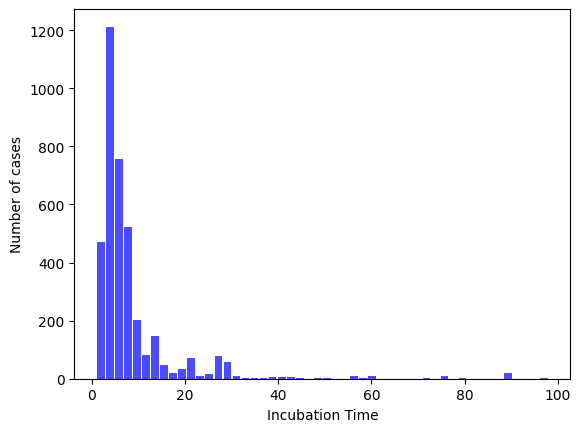

In [0]:
#----------------------------------------------
# Histogram of incubation period
#----------------------------------------------

plt.hist(keyword_time, bins = 50, density = False, color = 'blue', alpha=0.7, rwidth=0.85)
plt.ylabel("Number of cases")
plt.xlabel("Incubation Time")
plt.savefig('words', format='png', bbox_inches='tight', dpi=600)

In [0]:
mean_incubation_time = np.mean(keyword_time)
print("The mean projected incubation time is:",mean_incubation_time)

The mean projected incubation time is: 8.091908876669285


So, we can conclude that that the mean of incubation period for COVID-19 is about 8 days.

### 2.2. Risk Factor visualization

In this part, we first define a group of well-known discovered Risk Factors and then we scrutinize the selected papers (in which we had our keywords) to find the risk factor words. Finally, we visaluze the number of each risk factor that appeared near the incubation period words within all papers.

In [0]:
#----------------------------------------------
# Extracting Risk Factors from papers
#----------------------------------------------

RiskFactors = ['pulmonary', 'smoking', 'pregnancy', 'newborns', 'asthma', 'hiv', 'diabetes']
RF_count = dict((RF,0) for RF in RiskFactors)

for RF in RF_count:
    for t in text:
        if str(RF) in t:
            RF_count[RF] += 1


print(RF_count)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


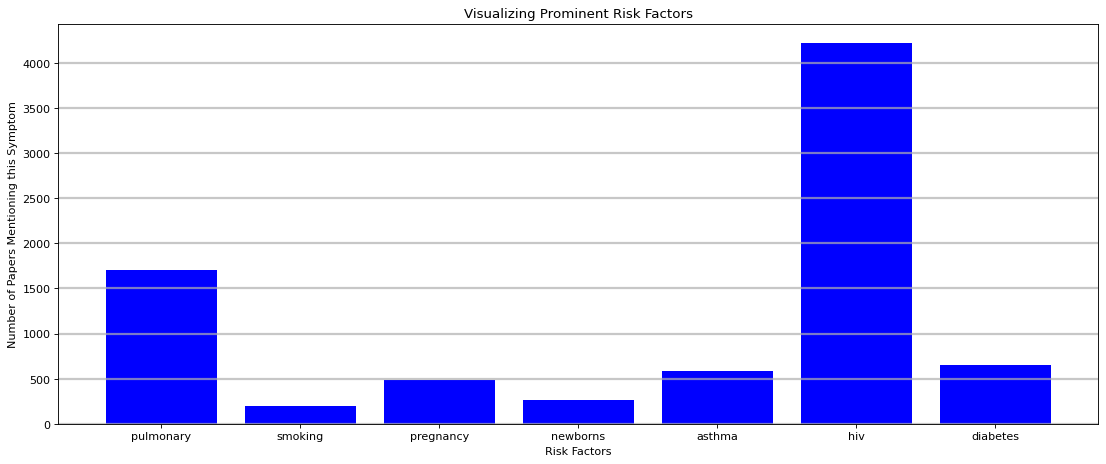

<Figure size 640x480 with 0 Axes>

In [0]:
#----------------------------------------------
# Visualizing the frequency of Risk Facotrs
#----------------------------------------------

loc = np.arange(len(RF_count))
width = 0.35

fig = plt.figure(num=None, constrained_layout=True, figsize=(13, 5), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_axes([0,0,1,1])

ax.bar(RF_count.keys(),RF_count.values(), color='blue')
ax.set_xticks(loc, tuple(RiskFactors))

ax.grid(linewidth=2, axis='y', alpha=0.7)
ax.set_ylabel('Number of Papers Mentioning this Symptom')
ax.set_xlabel('Risk Factors')
ax.set_title('Visualizing Prominent Risk Factors')
plt.show()
plt.savefig('riskFactors', format='png', bbox_inches='tight', dpi=600)

## Part 3: Model Selection and Development
This part includes two different sections:

- Unsupervised Machine Learning section: We use an unseupervised model to cluster the Risk Factors based on the incubation perido.
- Supervised Machine Learning section: We develop a supervised learning Regression model which is able to predict the incubation period based on the risk factors that each patient has.




### 3.1. Unsupervised Clustering

Clearly, we have a number of different risk factors that not all of them are dangerious equally. According to the structure of COVID-19 and its meachanism, some of these risk factors are more dangerous than the other ones and can lead to some severe conditions. In this part we want to cluster these risk factors to tow (or more) groups based on how dangerous and high risk they are. Among the the data we have, incubation period is the most appropriate parameter detemining how severe the patient condition is. namely, more dangerious / high risk-risk factors lead to longer incubation perods, whereas the less danegerous or low risk ones lead to shorter incubation periods.

Thus, we are going to find the nearest nearest risk factors to the incubation periods mentioned each text/paragraphs and then assign the found risk factors in that paragrpah to the incubation period of the patient. 

In [0]:
#----------------------------------------------
# Extracting feature vectors
#----------------------------------------------

features = []
keyword_time = list()

for t in text:
    vector = [0] * len(RiskFactors)
    for sentences in t.split(". "):
        for keyword in keywords:
            if keyword in sentences:
                single_day = re.findall(r" \d{1,2} day", sentences)

                for i in range(len(RiskFactors)):
                    if str(RiskFactors[i]) in t:
                        vector[i] = 1
                        
                if len(single_day) == 1:
                    num = single_day[0].split(" ")
                    keyword_time.append(float(num[1]))
                    features.append(vector)
                
features

[[0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 1, 1, 0],
 [1, 0, 0, 0, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0],
 [1, 1, 1, 0, 0, 1, 1],
 [1, 1, 1, 0, 0, 1, 1],
 [1, 1, 1, 0, 0, 1, 1],
 [1, 1, 1, 0, 0, 1, 1],
 [1, 1, 1, 0, 0, 1, 1],
 [1, 1, 1, 0, 0, 1, 1],
 [1, 1, 1, 0, 0,

In [0]:
Relations = pd.DataFrame(features, columns = RiskFactors)
Relations["Incubation Period"] = keyword_time

In [0]:
Relations

,pulmonary,smoking,pregnancy,newborns,asthma,hiv,diabetes,Incubation Period
0,0,0,0,0,0,0,0,5.0
1,1,0,0,0,0,0,0,3.0
2,1,1,0,0,1,0,0,4.0
3,0,0,0,0,0,0,0,10.0
4,0,0,0,0,0,1,0,3.0
...,...,...,...,...,...,...,...,...
3814,0,0,0,0,0,0,0,4.0
3815,0,0,0,0,0,0,0,7.0
3816,0,0,0,0,0,0,0,3.0
3817,0,0,0,0,0,0,0,5.0


Having explored the full text papers wich are related to incubation period, and extracting our listed risk facotrs, we can present the table above wich shows that for each of the mentioned patient how many risk factors they had and how many days it took for them to recover (i.e. incubation period).

As it can be seen from the table above, we cannot easily distinguish the dangerious risk fractors from the mild ones, due to the fact they are convoluted and many different combination of them we can have for each patient. So, we are going to use Hierarchical Clustering algorihtm to cluster the risk factors into different groups based on how dangerious they are.

Within the following cells, we create the distance matrix and calcualte the distance between each of the risk factors by using incubation period for each case. we calculate a distance value for each pair of risk factors based on the fact the they appeared in the patients with long incubation period (>mean of incubation period) or in short incubation period (<mean of incubation period) groups and whether they appeared togehter or not. 

In [0]:
#----------------------------------------------
# Creating distance Matrix
#----------------------------------------------

RF_dist = np.zeros((len(RiskFactors),len(RiskFactors)), dtype=float)

for i in range(len(RiskFactors)):
    for j in range(len(RiskFactors)):
        if i == j: 
            RF_dist[i][j] = 0

        if i!=j:
            tempSum = 0
            for doc in range(3700):                
                if ((Relations[str(RiskFactors[i])][doc] == 1) & (Relations[str(RiskFactors[j])][doc] == 1)):
                    if (Relations['Incubation Period'][doc] > mean_incubation_time):
                        tempSum += 1
                    elif (Relations['Incubation Period'][doc] <= mean_incubation_time):
                        tempSum -= 1
                elif ((Relations[str(RiskFactors[i])][doc] == 0) | (Relations[str(RiskFactors[j])][doc] == 0)):
                    tempSum +=0;
            
            RF_dist[i][j] = tempSum/Relations.size

df_distance = pd.DataFrame(RF_dist, columns=RiskFactors, index=RiskFactors)

In [0]:
df_distance

,pulmonary,smoking,pregnancy,newborns,asthma,hiv,diabetes
pulmonary,0.000000,0.000589,0.000295,0.001113,-0.001178,-0.001735,0.000393
smoking,0.000589,0.000000,0.000884,0.000786,0.001015,0.000786,0.000753
pregnancy,0.000295,0.000884,0.000000,0.000491,0.000622,-0.000065,0.000720
newborns,0.001113,0.000786,0.000491,0.000000,0.001342,0.000393,0.000982
asthma,-0.001178,0.001015,0.000622,0.001342,0.000000,0.000622,0.000720
hiv,-0.001735,0.000786,-0.000065,0.000393,0.000622,0.000000,-0.000033
diabetes,0.000393,0.000753,0.000720,0.000982,0.000720,-0.000033,0.000000


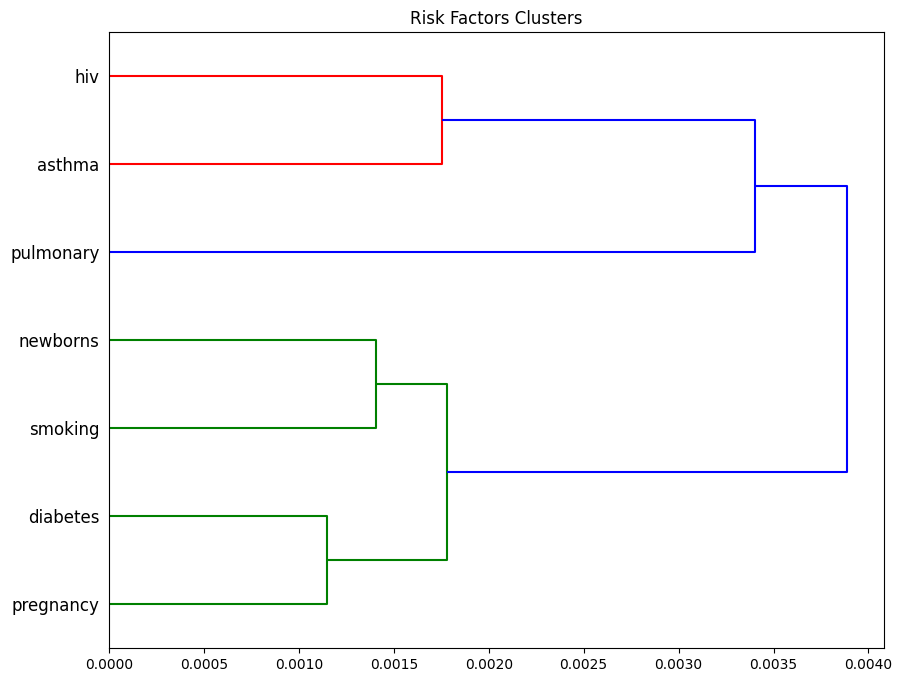

In [0]:
#----------------------------------------------
# Hierarchical Clustering Visualization
#----------------------------------------------

import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import ward, dendrogram

linkage = ward(RF_dist)

fig, ax = plt.subplots(figsize=(10, 8)) 
ax = dendrogram(linkage, labels=df_distance.columns, orientation='right') 
plt.title('Risk Factors Clusters')
plt.savefig('Clusters', format='png', bbox_inches='tight', dpi=600)

At this stage, our listed risk factors have been calssified to three main clusters. The most dangerous group of risk factor, consists of HIV and athsma, results in longest incubation periods. Then pulnomary illnesses will result in relatively long incubation period. Newborns, diabets, etc. are in the last group that need shorter incubation period of time for the patient to become recovered.

### 3.2. Supervised Logistic Regression Model

Up to now, we have clustered the risk factors into high-risk and low-risk groups based on how they affect the incubation period. Although it is helpful for prevention and qualitative studies, we need some more quantified data for a serous challenge. 

One of the most important concern of the governemnts all around the world right now, is managing the hospital capacities and incuabtion facilities in order to prevent running out of them. In this part, an ordinal logistic regression model is developed and presented based on the previous gathered data, which is able to predict the incubation period of time bucket that each patient requires based on the pre-existing condition and risk factors she/he had before being infected. This will help the hospitial administratives effectively to have an estimate on the required incubation period at the begining of the incubation process. This leads to better management of capacity and equipments.

#### 3.2.1 Oridinal Logistic Regression Implementation

Before going any furhter, we need to first split-up the incuabtion period data to different buckets to make the predition more feasible. We use three different buckets:
- Short-Term Incubation: Those patients who need a short time period of incubation (< mean)
- Long-Term Incubation: Those patients who need a Long time period of incubation (> mean and < 3mean)
- Extreme Incubation: Those patients who need a vary long time of incubation and are in severe condition. (3mean)

We assing number 0,1,2 to each of the above mentioned groups for classification.

In [0]:
#----------------------------------------------
# Encoding incubation period data
#----------------------------------------------

for i in range(3700):
    if (Relations['Incubation Period'][i] < mean_incubation_time):
        Relations['Incubation Period'][i] = 0
    elif ((Relations['Incubation Period'][i] > mean_incubation_time) and (Relations['Incubation Period'][i] < 3*mean_incubation_time)):
        Relations['Incubation Period'][i] = 1
    else:
        Relations['Incubation Period'][i] = 2 

In [0]:
Relations['Incubation Period'] = Relations['Incubation Period'].astype(int)
Relations.head(10)

,pulmonary,smoking,pregnancy,newborns,asthma,hiv,diabetes,Incubation Period
0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,1,1,0,0,1,0,0,0
3,0,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0
5,0,0,0,0,0,0,0,0
6,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,0,0
8,1,0,0,0,1,0,0,0
9,0,0,0,0,0,0,0,0


Having the incubation period data encoded, we can start split up our dataset to train and test group and then we can implement our model. Also we use 10-fold cross vallidation in our training. 

In [0]:
#----------------------------------------------
# Splitting up the data to train and test
#----------------------------------------------

X = Relations.drop(['Incubation Period'],axis=1)[:3700]
Y = Relations['Incubation Period'][:3700]

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X,Y,test_size=0.3, random_state=20)

In [0]:
#----------------------------------------------
# Ordinal Regression Model implementation
#----------------------------------------------

model_ord_Reg = mord.LogisticAT(alpha=1.)
MAE = make_scorer(mean_absolute_error)
folds = 10

print('Mean absolute error:' )

MAE_linear = cross_val_score(model_ord_Reg, X_Train, Y_Train, cv=folds, scoring=MAE)
print('Linear regression, mean of MAE: ', np.mean(MAE_linear))
print('Linear regression, var of MAE: ', np.var(MAE_linear))


Mean absolute error:
Linear regression, mean of MAE:  0.2698841698841699
Linear regression, var of MAE:  0.001223744428377633


In [0]:
#----------------------------------------------
# Testing the trained model on test data
#----------------------------------------------

model_ord_Reg.fit(X_Train, Y_Train)
predictions = model_ord_Reg.predict(X_Test)
print(classification_report(Y_Test, predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.81      0.96      0.88       873
           1       0.33      0.16      0.22       165
           2       0.00      0.00      0.00        72

    accuracy                           0.78      1110
   macro avg       0.38      0.37      0.37      1110
weighted avg       0.69      0.78      0.72      1110



In [0]:
f1_score(Y_Test, predictions, average='micro')

0.7765765765765765

The obtained accuary value based on f1 score, that is 78% is quite acceptable for prediction of incubation period.

#### 3.2.2 Hyperparameter Tuning

At this step, GridSearch Cross-Validation was used to tune the hyperparameters our best performed model.
The whole process as follows: 
- We define the hyperparameter space.
- And with every candidate hyperparameter, we will split the data into train and test, train the model on train and then score on test data. 
- Finally, GridSearchCV obtain the best hyperparameters based on the scores.

In [0]:
#----------------------------------------------
# Hyperparameter tuning of the model
#----------------------------------------------

from sklearn.model_selection import GridSearchCV
folds=10
# Alpha = np.logspace(-1, 2, 1000, endpoint=False)
Alpha = np.linspace(1.0, 100.0, num=1000, endpoint=False)


train_scores = []
for a in Alpha:
  model_ord_Reg = mord.LogisticAT(alpha=a)
  model_ord_Reg.fit(X_Train, Y_Train)
  predictions = model_ord_Reg.predict(X_Train)
  train_scores.append(f1_score(Y_Train, predictions, average='micro'))

alpha_best = Alpha[train_scores.index(max(train_scores))]
print(train_scores)
print('Best Alpha:', alpha_best ,', Accuracy = ', max(train_scores))

[0.7760617760617761, 0.7760617760617761, 0.7760617760617761, 0.7772200772200772, 0.7772200772200772, 0.7772200772200772, 0.7772200772200772, 0.7772200772200772, 0.7772200772200772, 0.7772200772200772, 0.7772200772200772, 0.7772200772200772, 0.7772200772200772, 0.7772200772200772, 0.7772200772200772, 0.7772200772200772, 0.7772200772200772, 0.7772200772200772, 0.7772200772200772, 0.7772200772200772, 0.7772200772200772, 0.7772200772200772, 0.7772200772200772, 0.7783783783783784, 0.7783783783783784, 0.7783783783783784, 0.7783783783783784, 0.7783783783783784, 0.7783783783783784, 0.7783783783783784, 0.7783783783783784, 0.7783783783783784, 0.7783783783783784, 0.7783783783783784, 0.7783783783783784, 0.7783783783783784, 0.7783783783783784, 0.7783783783783784, 0.7783783783783784, 0.7783783783783784, 0.7783783783783784, 0.7783783783783784, 0.7783783783783784, 0.7783783783783784, 0.7783783783783784, 0.7783783783783784, 0.7783783783783784, 0.7783783783783784, 0.7783783783783784, 0.7783783783783784,

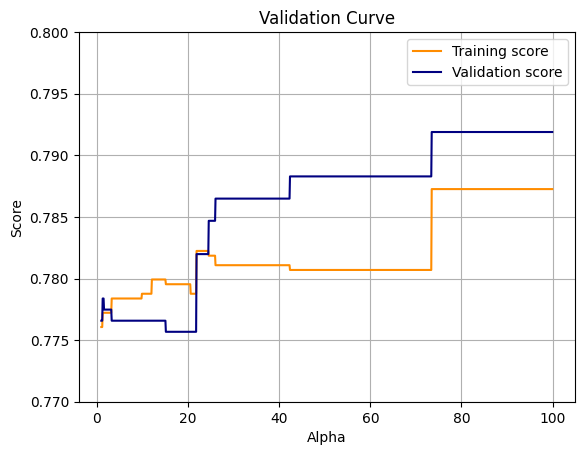

<Figure size 640x480 with 0 Axes>

In [0]:
#----------------------------------------------
# Obtaining the learning Curve 
#----------------------------------------------

test_scores = []
for a in Alpha:
  model_ord_Reg = mord.LogisticAT(alpha=a)
  model_ord_Reg.fit(X_Train, Y_Train)
  predictions = model_ord_Reg.predict(X_Test)
  test_scores.append(f1_score(Y_Test, predictions, average='micro'))

plt.title("Validation Curve")
axes = plt.gca()
plt.grid()
plt.xlabel(r"Alpha")
plt.ylabel("Score")
axes.set_ylim(0.77, 0.8)

plt.plot(Alpha, train_scores, label="Training score", color="darkorange")
plt.plot(Alpha, test_scores, label="Validation score",  color="navy")
plt.legend(loc="best")
plt.show()
plt.savefig('learningCurve', format='png', bbox_inches='tight', dpi=600)

In this plot you can see the training scores and validation scores of oordinal logistic regression model for different values of the kernel parameter Alpha. For very low values of Alpha, you can see that both the training score and the validation score are lower than the other values of Alpha. This is called underfitting. As the Alpha increases the score value increases for both validation and testing sets. We have no over-fitting here beacuse both training and testing set scores are high enough for all Alphas.

## Part4: Discussion

In this project we aimed to help fighting with COVID-19 catastrophy from a data scientist point of view. To do this we decided to study the effect of the Risk Factors and pre-existing illness of the patients on their incubation period of time. Having loaded and cleaned the dataset of papers which have been published recently, we mined the full text papers, sentence by sentence, to find the incubation period of time and the related risk factors which are mentioned in the body of the text. Then by assigning a vecotor of 1 and 0 to each case we determined whether that specific risk factor exists in that case or not. As of now, we proceed the project in two sections:
- In the first Section, by taking advantage of Hierarchical Clustering algorihtm we clustered the risk factors into 3 main groups in terms of their danger and the incubation preiod required for recovery. The most dangerous group of risk factor, consists of HIV and athsma, results in longest incubation periods. Then pulnomary illnesses will result in relatively long incubation period. Newborns, diabets, etc. are in the last group that need shorter incubation period of time for the patient to be recovered. Government can use this qualitative analysis to increase the general awareness of the society that helps people with different types of risk factors to understand the risk of being infected. As a result, they will be able to take the precautions accordingly.
- Within the second section, we performed a more quantitative analysis by exaclty determining the incubation period bucket by taking the risk factors that the patient has. To achieve this, an Ordinal Logistic Regression Model that by taking the vector of risk factor presence can determine the bucket of incubation period that is required for complete recovery of the patient. Finally, hyperparameter tuning was performed to obtain 78% of accuracy which is quite acceptable for our application. 
This will help the hospitial administratives and health officials effectively to have an estimate on the required incubation period at the begining of the incubation process. This leads to better management of capacity and equipments.